In [33]:
#  AOI_domainGEN for TESSFA

import netCDF4 as nc
import numpy as np
from pyproj import Transformer
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import pandas as pd
import sys, os

from datetime import datetime

# Get current date
current_date = datetime.now()
# Format date to mmddyyyy
formatted_date = current_date.strftime('%y%m%d')

# An input csv file that contains the locations of land gridcells in Daymet domain;
# 1:  land gridcell ID
# 2:  xc, yc (lon, lat) of land gridcell center 
# 3:  xc_LCC,yc_LCC (x,y) location in LLC projection

# output 1D AOIdomain.nc that can be used to generate 1D AOIsurfdata.nc and 1D AOIforcing.nc 

def read_gridcells(file_name):
    try:
        df = pd.read_csv(file_name, sep=",")
    except pd.errors.ParserError:
        df = pd.read_csv(file_name, sep=" ")
    return df

def find_nearest_points(listA, listB):
    tree = cKDTree(np.array(listB))
    _, indices = tree.query(listA, k=1)
    return indices

def main():
    '''
    args = sys.argv[1:]
    # Check the number of arguments
    if len(sys.argv) != 4  or sys.argv[1] == '--help':  # sys.argv includes the script name as the first argument
        print("Example use: python AOI_domainGEN.py <input_path> <output_path> <AOI_points_file>")
        print(" <input_path>: path to the 1D source data directory")
        print(" <output_path>:  path for the 1D AOI output data directory")
        print(" <AOI_points_file>:  <AOI>_gridID.csv or <AOI>_xcyc.csv or <AOI>_xcyc_lcc.csv")
        print(" The code uses NA forcing to generation 1D AOI domain.nc")      
        exit(0)

    input_path = args[0]
    output_path = args[1]
    AOI_gridcell_file = args[2]
    AOI=AOI_gridcell_file.split("_")[0]
    '''
    input_path = '/gpfs/wolf2/cades/cli185/proj-shared/Daymet_GSWP3_4KM_TESSFA/ELMinputdata/domain1D_TES/'
    output_path = './temp/AOI_domain1D/'
    #AOI_gridcell_file = 'MOFlux_region.xcyc.csv'
    AOI_gridcell_file = 'MOF21points_xcyc.csv'
    AOI=AOI_gridcell_file.split("_")[0]

    if AOI_gridcell_file.endswith('gridID.csv'):
        user_option = 1
    if AOI_gridcell_file.endswith('xcyc.csv'):
        user_option = 2
    if AOI_gridcell_file.endswith('xcyc_lcc.csv'):
        user_option = 3

    source_file = input_path + '/'+ 'domain.lnd.Daymet_GSWP3_TESSFA.4km.1d.c240322.nc' 
    print("Source file is: ",source_file)

    # save to the 1D domain file
    AOIdomain = output_path + '/' + str(AOI)+'_domain.lnd.Daymet_GSWP3_TESSFA.4km.1d.c' + formatted_date + '.nc'
    print("Generating domain file: ", AOIdomain)
    # check if file exists then delete it
    if os.path.exists(AOIdomain):
        os.remove(AOIdomain)
    
    dst = nc.Dataset(AOIdomain, 'w', format='NETCDF4')

    # open the 1D domain data
    src = nc.Dataset(source_file, 'r', format='NETCDF4')

    # 3) Open a csv file to read a list of points (y, x)
    #df = read_gridcells(AOI_gridcell_file)  

    if user_option == 1: # gridID is used directly
        #AOI_gridcell_file = AOI+'_gridID.csv'  # user provided gridcell IDs
        df = pd.read_csv(AOI_gridcell_file, sep=",", skiprows=1, names = ['gridID'])
        #read gridIds
        AOI_points = list(df['gridID'])
        #AOI_points = list(mygridIDs)

        # read gridIDs
        NA_gridIDs = src.variables['gridID'][:]
        NA_gridcell_list = list(NA_gridIDs)
        print(NA_gridcell_list[0:5])

        domain_idx = np.where(np.in1d(NA_gridcell_list, AOI_points))[0]

    if user_option == 2: # use lon lat coordinates
        #AOI_gridcell_file = AOI+'_xcyc.csv'  # user provided gridcell csv file  (xc, yc) (lon, lat)
        df = pd.read_csv(AOI_gridcell_file, sep=",", skiprows=1, names = ['xc', 'yc'], engine='python')

        #read in x, y coordinate (lon, lat)
        AOI_points = list(zip(df['xc'], df['yc']))
        #AOI_points = list(zip(myxc, myyc))
        
        # read yc, xc (y, x)
        NA_yc = src.variables['yc'][:]
        NA_xc = src.variables['xc'][:]
        # create list for all land gridcell (lat, lon)
        NA_gridcell_list = list(zip(NA_xc, NA_yc))
 
        # find the xc, yc boundary
        NA_xc_max, NA_xc_min = np.max(NA_xc), np.min(NA_xc)
        NA_yc_max, NA_yc_min = np.max(NA_yc), np.min(NA_yc)

        #check the boundaries
        for i, pt in enumerate(AOI_points):
            pt_x, pt_y = pt
            #print (pt_x, NA_xc_min, NA_xc_min.shape)
            if pt_x > NA_xc_max or pt_x < NA_xc_min or pt_y > NA_yc_max or pt_y < NA_yc_min:
                AOI_points.remove(pt)
                print(f"point {i} ({pt_x},{pt_y}) is out of TES domain and is removed")


        AOI_points_arr = np.array(AOI_points)
        print("AOI_points_arr", AOI_points_arr[0:5], "shape", AOI_points_arr.shape)
        NA_gridcell_arr = np.squeeze(np.array(NA_gridcell_list)).transpose()    
        print("NA_gridcell_arr", NA_gridcell_arr[0:5], "shape", NA_gridcell_arr.shape)

        tree = cKDTree(NA_gridcell_arr)
        _, domain_idx = tree.query(AOI_points_arr, k=1)

    if user_option == 3: # xc_LCC and yc_LCC is used directly
        #AOI_gridcell_file = AOI+'_XYLCC.csv'  # user provided gridcell csv file  (xc_LCC, yc_LCC) 
        df = pd.read_csv(AOI_gridcell_file, sep=",", skiprows=1, names = ['xc_LCC', 'yc_LCC'], engine='python')

        #read in x, y coordinate (in LCC projection)
        AOI_points = list(zip(df['xc_LCC'], df['yc_LCC']))
        #AOI_points = list(zip(myxc_lcc, myyc_lcc))

        # read yc_LCC, xc_LCC (y, x in LCC)
        NA_yc_LCC = src.variables['yc_LCC'][:]
        NA_xc_LCC = src.variables['xc_LCC'][:]

        # create list for all land gridcell (lat, lon)
        NA_gridcell_list = list(zip(NA_xc_LCC, NA_yc_LCC))


        # find the xc, yc boundary
        NA_xc_LCC_max, NA_xc_LCC_min = np.max(NA_xc_LCC), np.min(NA_xc_LCC)
        NA_yc_LCC_max, NA_yc_LCC_min = np.max(NA_yc_LCC), np.min(NA_yc_LCC)

        #check the boundaries
        for i, pt in enumerate(AOI_points):
            pt_x, pt_y = pt
            #print (pt_x, NA_xc_LCC_min, NA_xc_LCC_min.shape)
            if pt_x > NA_xc_LCC_max or pt_x < NA_xc_LCC_min or pt_y > NA_yc_LCC_max or pt_y < NA_yc_LCC_min:
                AOI_points.remove(pt)
                print(f"point {i} ({pt_x},{pt_y}) is out of Daymet domain and is removed")

        AOI_points_arr = np.array(AOI_points)
        print("AOI_points_arr", AOI_points_arr[0:5], "shape", AOI_points_arr.shape)
        NA_gridcell_arr = np.squeeze(np.array(NA_gridcell_list)).transpose()    
        print("NA_gridcell_arr", NA_gridcell_arr[0:5], "shape", NA_gridcell_arr.shape)

        tree = cKDTree(NA_gridcell_arr)
        _, domain_idx = tree.query(AOI_points_arr, k=1)

    #domain_idx = np.sort(domain_idx).squeeze()

    print("gridID_idx", domain_idx[0:20])
    #if not user_option==1:
    #    np.savetxt("AOI_gridId.csv", src['gridID'][...,domain_idx], delimiter=",", fmt='%d\n')

    # Copy the global attributes from the source to the target
    for name in src.ncattrs():
        dst.setncattr(name, src.getncattr(name))

    # Copy the dimensions from the source to the target
    for name, dimension in src.dimensions.items():
        if name != 'ni':
            dst.createDimension(
                name, (len(dimension) if not dimension.isunlimited() else None))
        else:
            # Update the 'ni' dimension with the length of the list
            #dst.dimensions['ni'].set_length(len(AOI_points))
            ni = dst.createDimension("ni", len(AOI_points))

    # Copy the variables from the source to the target
    for name, variable in src.variables.items():
        x = dst.createVariable(name, variable.datatype, variable.dimensions)   
        print(name, variable.dimensions)
        
        if (name != 'lambert_conformal_conic'):
            if (variable.dimensions[-1] != 'ni'):
                dst[name][...] = src[name][...]
            else:
                dst[name][...] = src[name][...,domain_idx]
           
        # Copy the variable attributes
        for attr_name in variable.ncattrs():
            dst[name].setncattr(attr_name, variable.getncattr(attr_name))

    dst.title = '1D domain for '+ AOI +', generated on ' +formatted_date + ' with ' + source_file
       
    # Close the source netCDF file
    src.close()

    # Save the target netCDF file
    dst.close()

#if __name__ == '__main__':
#    main()
main()


Source file is:  /gpfs/wolf2/cades/cli185/proj-shared/Daymet_GSWP3_4KM_TESSFA/ELMinputdata/domain1D_TES//domain.lnd.Daymet_GSWP3_TESSFA.4km.1d.c240322.nc
Generating domain file:  ./temp/AOI_domain1D//MOF21points_domain.lnd.Daymet_GSWP3_TESSFA.4km.1d.c240323.nc
AOI_points_arr [[-92.     38.   ]
 [-92.     38.042]
 [-92.     38.083]
 [-92.     38.125]
 [-92.     38.167]] shape (21, 2)
NA_gridcell_arr [[-81.375   30.2083]
 [-81.625   30.25  ]
 [-81.5833  30.25  ]
 [-81.5417  30.25  ]
 [-81.5     30.25  ]] shape (558794, 2)
gridID_idx [82578 83163 83747 84333 84922 85512 86101 86692 87286 87882 88480 89077
 89675 90271 90866 91461 92056 92650 93245 93840]
x ('x',)
y ('y',)
gridID ('nj', 'ni')
gridXID ('nj', 'ni')
gridYID ('nj', 'ni')
xc ('nj', 'ni')
yc ('nj', 'ni')
xc_LCC ('nj', 'ni')
yc_LCC ('nj', 'ni')
xv ('nv', 'nj', 'ni')
yv ('nv', 'nj', 'ni')
area ('nj', 'ni')
area_LCC ('nj', 'ni')
mask ('nj', 'ni')
frac ('nj', 'ni')
lambert_conformal_conic ()


In [57]:

# AOI_forcingGEN for TESSFA

import os,sys
import netCDF4 as nc
import numpy as np
import pandas as pd
from time import process_time
from datetime import datetime

# Get current date
current_date = datetime.now()
# Format date to mmddyyyy
formatted_date = current_date.strftime('%m%d%Y')

def AOI_forcing_save_1d(input_path, file, AOI, AOI_points, output_path):
    # Open a new NetCDF file to write the data to. For format, you can choose from
    # 'NETCDF3_CLASSIC', 'NETCDF3_64BIT', 'NETCDF4_CLASSIC', and 'NETCDF4'
    source_file = input_path + '/'+ file
    print ("Opening source file: ", source_file)
    src = nc.Dataset(source_file, 'r', format='NETCDF4')
    
    #read gridIDs
    grid_ids = src['gridID'][...]    # gridID for all NA
 
    #  
    AOI_idx = np.where(np.in1d(grid_ids, AOI_points))[0]
    
    # create the new_filename
    dst_name = output_path + '/'+ AOI + '_'+file
    print ("Generating AOI file: ", dst_name)
    
    # check if file exists then delete it
    if os.path.exists(dst_name):
        os.remove(dst_name)
    
    # Open a new NetCDF file to write the data to. For format, you can choose from
    # 'NETCDF3_CLASSIC', 'NETCDF3_64BIT', 'NETCDF4_CLASSIC', and 'NETCDF4'
    dst = nc.Dataset(dst_name, 'w', format='NETCDF4')
    dst.title = './'+ AOI + '/'+file+' creted from '+ source_file +' on ' +formatted_date

    # Copy the global attributes from the source to the target
    for name in src.ncattrs():
        dst.setncattr(name, src.getncattr(name))

    # Copy the dimensions from the source to the target
    for name, dimension in src.dimensions.items():
        if name != 'ni' and name != 'gridcell':
            dst.createDimension(
                name, (len(dimension) if not dimension.isunlimited() else None))
        else:
            # Update the 'ni' dimension with the length of the list
            #dst.dimensions['ni'].set_length(len(AOI_points))
            if name == 'ni' or name == 'gridcell': 
                ni = dst.createDimension(name, AOI_points.size)

    # Copy the variables from the source to the target
    for name, variable in src.variables.items():
        x = dst.createVariable(name, variable.datatype, variable.dimensions)   
        print(name, variable.dimensions)
        
        if (name != 'lambert_conformal_conic'):
            if variable.dimensions[-1] != 'ni' and variable.dimensions[-1] != 'gridcell':
                dst[name][...] = src[name][...]
            else:
                dst[name][...] = src[name][..., AOI_idx]
           
        # Copy the variable attributes
        for attr_name in variable.ncattrs():
            dst[name].setncattr(attr_name, variable.getncattr(attr_name))
        
    src.close()  # close the source file 
    dst.close()  # close the new file        
    
def get_files(input_path):
    print(input_path)
    files = os.listdir(input_path) 

    files.sort() 

    file_no =0

    files_nc = [f for f in files if (f[-2:] == 'nc')] 
    print("total " + str(len(files_nc)) + " files need to be processed")
    return files_nc

def main():
    args = sys.argv[1:]
    '''
    if len(sys.argv) != 4  or sys.argv[1] == '--help':  # sys.argv includes the script name as the first argument
        print("Example use: python AOI_forcingGEN.py <input_path> <output_path> <AOI_points_file>")
        print(" <input_path>: path to the 1D source data directory")
        print(" <output_path>:  path for the 1D AOI forcing data directory")
        print(" <AOI_points_file>:  <AOI>_gridID.csv or <AOI>_domain.nc")
        print(" The code uses NA forcing to generation 1D AOI forcing")              
        exit(0)
    
    input_path = args[0]
    if not input_path.endswith("/"): input_path=input_path+'/'
    output_path = args[1]
    if not output_path.endswith("/"): output_path=output_path+'/'
    AOI_gridID_file = args[2]
    AOI=AOI_gridID_file.split("_")[0]
    '''
    
    #input_path = '/gpfs/wolf2/cades/cli185/proj-shared/Daymet_GSWP3_4KM_TESSFA/ELMinputdata/forcing1D_TES/'
    #input_path = '/gpfs/wolf2/cades/cli185/proj-shared/Daymet_GSWP3_4KM_TESSFA/ELMinputdata/'
    input_path = '/gpfs/wolf2/cades/cli185/proj-shared/Daymet_GSWP3_4KM_TESSFA/ELMinputdata/forcing1D_TES/netcdf/1998/'
    output_path = "./temp/dir2"
    AOI_gridID_path = '/gpfs/wolf2/cades/cli185/proj-shared/Daymet_GSWP3_4KM_TESSFA/ELMinputdata/AOI_data/MOFLUX/AOI_domain1D/'
    AOI_gridID_file = 'MOF21points_domain.lnd.Daymet_GSWP3_TESSFA.4km.1d.c231120.nc'
    AOI=AOI_gridID_file.split("_")[0]
    
    AOI_gridID_file = AOI_gridID_path + AOI_gridID_file
    
    if (AOI_gridID_file.endswith('.csv')):
        #AOI_gridcell_file = AOI+'_gridID.csv'  # user provided gridcell IDs
        df = pd.read_csv(AOI_gridID_file, sep=",", skiprows=1, names = ['gridID'])
        #read gridIds
        AOI_points = np.array(df['gridID'])
    elif AOI_gridID_file.endswith('.nc'):
        src = nc.Dataset(AOI_gridID_file, 'r')
        AOI_points = src['gridID'][:]
    else:
        print("Error: Invalid AOI_points_file, see help.")

    print(AOI_gridID_file)
        
    '''files_nc = get_files(input_path)

    for f in files_nc: 
        if (not f.startswith('clmforc')): continue
        print('processing '+ f )
        start = process_time() 
        AOI_forcing_save_1d(input_path, f, AOI, AOI_points, output_path)
        end = process_time()
        print("Generating 1D forcing data for "+AOI+ " domain takes {}".format(end-start))'''

    # Iterate over all subdirectories in the input directory
    for root, dirs, files in os.walk(input_path):
        for file in files:
            # Check if the file ends with '.nc'
            if file.endswith('.nc'):
                # Parse the filename into separate substrings
                parts = file.split('.')
                var_name = parts[3]
                period = parts[4]         
                print('processing '+ var_name + '(' + period + ') in the file ' + file )
                # Create the corresponding subfolder in the output directory
                new_dir = os.path.join(output_path, os.path.relpath(root, input_path))
                os.makedirs(new_dir, exist_ok=True)
                start = process_time()
                # Copy the file to the new location
                print(root, new_dir)
                #forcing_save_1dTES(root, file, var_name, period, time, new_dir)

                start = process_time() 
                AOI_forcing_save_1d(root, file, AOI, AOI_points, new_dir)
                end = process_time()
                print("Generating 1D forcing data for "+AOI+ " domain takes {}".format(end-start))

#if __name__ == '__main__':
#    main()
main() 

/gpfs/wolf2/cades/cli185/proj-shared/Daymet_GSWP3_4KM_TESSFA/ELMinputdata/AOI_data/MOFLUX/AOI_domain1D/MOF21points_domain.lnd.Daymet_GSWP3_TESSFA.4km.1d.c231120.nc
processing 1d(Prec) in the file clmforc.Daymet_GSWP3_TESSFA.4km.1d.Prec.1998-01.nc
/gpfs/wolf2/cades/cli185/proj-shared/Daymet_GSWP3_4KM_TESSFA/ELMinputdata/forcing1D_TES/netcdf/1998/Precip3Hrly ./temp/dir2/Precip3Hrly
Opening source file:  /gpfs/wolf2/cades/cli185/proj-shared/Daymet_GSWP3_4KM_TESSFA/ELMinputdata/forcing1D_TES/netcdf/1998/Precip3Hrly/clmforc.Daymet_GSWP3_TESSFA.4km.1d.Prec.1998-01.nc
Generating AOI file:  ./temp/dir2/Precip3Hrly/MOF21points_clmforc.Daymet_GSWP3_TESSFA.4km.1d.Prec.1998-01.nc
gridID ('nj', 'ni')
LONGXY ('nj', 'ni')
LATIXY ('nj', 'ni')
time ('time',)
PRECTmms ('time', 'nj', 'ni')
Generating 1D forcing data for MOF21points domain takes 9.019664079999984
processing 1d(Prec) in the file clmforc.Daymet_GSWP3_TESSFA.4km.1d.Prec.1998-02.nc
/gpfs/wolf2/cades/cli185/proj-shared/Daymet_GSWP3_4KM_TESSFA/

In [34]:
# AOI_surfdataGEN for TESSFA

import netCDF4 as nc
import numpy as np
from pyproj import Transformer
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import pandas as pd
import sys, os

from datetime import datetime

# Get current date
current_date = datetime.now()
# Format date to yymmdd
formatted_date = current_date.strftime('%y%m%d')

def main():
    '''
    args = sys.argv[1:]
    # Check the number of arguments
    if len(sys.argv) != 4  or sys.argv[1] == '--help':  # sys.argv includes the script name as the first argument
        print("Example use: python AOI_surfdataGEN.py <input_path> <output_path> <AOI_points_file>")
        print(" <input_path>: path to the 1D source data directory")
        print(" <output_path>:  path for the 1D AOI surface data directory")
        print(" <AOI_points_file>:  <AOI>_gridID.csv or <AOI>_domain.nc")
        print(" The code uses NA forcing to generation 1D AOI forcing")      
        exit(0)

    input_path = args[0]
    if not input_path.endswith("/"): input_path=input_path+'/'
    output_path = args[1]
    if not output_path.endswith("/"): output_path=output_path+'/'
    AOI_gridID_file = args[2]
    AOI=AOI_gridID_file.split("_")[0]

    '''
    input_path = '/gpfs/wolf2/cades/cli185/proj-shared/Daymet_GSWP3_4KM_TESSFA/ELMinputdata/surfdata1D_TES/'
    output_path = './temp/AOI_surfdata1D/'
    AOI_gridID_path = '/gpfs/wolf2/cades/cli185/proj-shared/wangd/kiloCraft/NA_domainGEN'
    AOI_gridID_file = 'MOFlux_domain.lnd.Daymet4.4km.1d.c231120.nc'
    #AOI_gridID_file = 'MOF21points_domain.lnd.Daymet_GSWP3_TESSFA.4km.1d.c231120.nc'
    AOI=AOI_gridID_file.split("_")[0]

    AOI_gridID_file = AOI_gridID_path + '/' + AOI_gridID_file
    
    if (AOI_gridID_file.endswith('.csv')):
        #AOI_gridcell_file = AOI+'_gridID.csv'  # user provided gridcell IDs
        df = pd.read_csv(AOI_gridID_file, sep=",", skiprows=1, names = ['gridID'])
        #read gridIds
        AOI_points = np.array(df['gridID'])
    elif AOI_gridID_file.endswith('.nc'):
        src = nc.Dataset(AOI_gridID_file, 'r')
        AOI_points = src['gridID'][:]
    else:
        print("Error: Invalid AOI_points_file, see help.")


    source_file = input_path+ 'surfdata.lnd.Daymet_GSWP3_TESSFA.4km.1d.c240323.nc'
    print("Source file is: ",source_file)

    # save to the 1D domain file
    AOIsurfdata = output_path + str(AOI)+'_surfdata.lnd.Daymet_GSWP3_TESSFA.4km.1d.'+ formatted_date +'.nc'
    print("Generating surfdata file: ", AOIsurfdata)
    
    # check if file exists then delete it
    if os.path.exists(AOIsurfdata):
        os.remove(AOIsurfdata)
    
    dst = nc.Dataset(AOIsurfdata, 'w', format='NETCDF4')

    # open the 1D domain data
    src = nc.Dataset(source_file, 'r', format='NETCDF4')

    # read gridIDs from src file
    NA_gridIDs = src.variables['gridID'][:]
    NA_gridcell_list = list(NA_gridIDs)
    print(NA_gridcell_list[0:5])

    # get the index of AOI_points in the NA_gridcell_list
    domain_idx = np.where(np.in1d(NA_gridcell_list, AOI_points))[0]

    # domain_idx = np.sort(domain_idx).squeeze()
    print("gridID_idx", domain_idx[0:10])

    # Copy the global attributes from the source to the target
    for name in src.ncattrs():
        dst.setncattr(name, src.getncattr(name))

    # Copy the dimensions from the source to the target
    for name, dimension in src.dimensions.items():
        if name != 'gridcell':
            dst.createDimension(
                name, (len(dimension) if not dimension.isunlimited() else None))
        else:
            # Update the 'ni' dimension with the length of the list
            #dst.dimensions['ni'].set_length(len(AOI_points))
            ni = dst.createDimension('gridcell', AOI_points.size)

    # Copy the variables from the source to the target
    for name, variable in src.variables.items():

        if (len(variable.dimensions) == 0 or variable.dimensions[-1] != 'gridcell'):
            x = dst.createVariable(name, variable.datatype, variable.dimensions)   
            print(name, variable.dimensions)
            # Copy variable attributes
            dst[name].setncatts(src[name].__dict__)
            # Copy the data
            dst[name][...] = src[name][...]

        else:
            if len(variable.dimensions) == 1:
                x = dst.createVariable(name, variable.datatype, ('gridcell',))   
                print(name, dst[name].dimensions)           
                dst[name][:] = src[name][domain_idx]
            if len(variable.dimensions) == 2:
                x = dst.createVariable(name, variable.datatype, variable.dimensions[:-1]+('gridcell',))   
                print(name, dst[name].dimensions)               
                for index in range(variable.shape[0]):
                    # get all the source data (global)
                    dst[name][index,:] = src[name][index][domain_idx]
            if len(variable.dimensions) == 3:
                x = dst.createVariable(name, variable.datatype, variable.dimensions[:-1]+('gridcell',))   
                print(name, dst[name].dimensions)   
                for index1 in range(variable.shape[0]):
                    for index2 in range(variable.shape[1]):
                        # get all the source data (global)
                        dst[name][index1,index2,:] = src[name][index1][index2][domain_idx]
            # Copy variable attributes (except _FillValue)
            attrs = dict(src[name].__dict__)
            attrs.pop('_FillValue', None)
            dst[name].setncatts(attrs)

    dst.title = '1D surfdata for '+ AOI +', generated on ' +formatted_date + ' with ' + source_file
       
    # Close the source netCDF file
    src.close()

    # Save the target netCDF file
    dst.close()

    print("Surfdata generation complete!")

#if __name__ == '__main__':
#    main()
main()

Source file is:  /gpfs/wolf2/cades/cli185/proj-shared/Daymet_GSWP3_4KM_TESSFA/ELMinputdata/surfdata1D_TES/surfdata.lnd.Daymet_GSWP3_TESSFA.4km.1d.c240323.nc
Generating surfdata file:  ./temp/AOI_surfdata1D/MOFlux_surfdata.lnd.Daymet_GSWP3_TESSFA.4km.1d.240323.nc
[9596, 11295, 11296, 11297, 11298]
gridID_idx [82578 82579 82580 82581 82582 82583 82584 82585 82586 82587]
lon ('lon',)
lat ('lat',)
lon2D ('lat', 'lon')
lat2D ('lat', 'lon')
gridID ('gridcell',)
gridXID ('gridcell',)
gridYID ('gridcell',)
mxsoil_color ()
mxsoil_order ()
SOIL_COLOR ('gridcell',)
SOIL_ORDER ('gridcell',)
PCT_SAND ('nlevsoi', 'gridcell')
PCT_CLAY ('nlevsoi', 'gridcell')
ORGANIC ('nlevsoi', 'gridcell')
FMAX ('gridcell',)
natpft ('natpft',)
LANDFRAC_PFT ('gridcell',)
PFTDATA_MASK ('gridcell',)
PCT_NATVEG ('gridcell',)
PCT_CROP ('gridcell',)
PCT_NAT_PFT ('natpft', 'gridcell')
MONTHLY_LAI ('time', 'lsmpft', 'gridcell')
MONTHLY_SAI ('time', 'lsmpft', 'gridcell')
MONTHLY_HEIGHT_TOP ('time', 'lsmpft', 'gridcell')
MONTH

In [ ]:
# AOI_forcingGEN for TESSFA

import os,sys 
import netCDF4 as nc
import numpy as np
from time import process_time
from datetime import datetime

# Get current date
current_date = datetime.now()
# Format date to mmddyyyy
formatted_date = current_date.strftime('%m%d%Y')

def forcing_save_1dTES(input_path, file, var_name, period, time, output_path):
    # Open a new NetCDF file to write the data to. For format, you can choose from
    # 'NETCDF3_CLASSIC', 'NETCDF3_64BIT', 'NETCDF4_CLASSIC', and 'NETCDF4'
    source_file = input_path + '/'+ file
    src = nc.Dataset(source_file, 'r', format='NETCDF4')
    
    # Parse the filename into separate substrings
    parts = file.split('.')
    parts.insert(3, '1d')
    # Join the parts back together to form the new filename
    new_filename = '.'.join(parts)
    
    total_rows = src.dimensions['lon'].size
    total_cols = src.dimensions['lat'].size
    total_time = src.dimensions['time'].size

    #print('total timesteps is :' + str(total_timesteps))
    if time == -1:
        time = total_time

    lat= src['lat'][:]
    lon= src['lon'][:]

    lonxy, latxy = np.meshgrid(lon, lat)

    #print(lonxy.shape)

    # time in 'days since ' current yyyy-mm-01-01 00:00:00
    data_time = src['time'][0:time] # read (time, y, x) format
    tunit = src.variables['time'].getncattr('units')  # Kao's data is with datetime of leap-year 
    t0=str(tunit.lower()).strip('days since')
    t0=datetime.strptime(t0,'%Y-%m-%d %X')
    iyr = t0.year + np.floor(data_time/365.0)
    data_time0 = datetime.strptime(str(int(iyr[0]))+'-01-01','%Y-%m-%d')
    data_time0 = (data_time0-t0).total_seconds()/86400.0  # days from t0 at the beginning of year
    iday = data_time - data_time0   # now in DOY of leapyear format, will be re-filled below
    imm = np.zeros_like(iday)
    mdoy = [0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 365]
    for m in range(1,12):
        tpts = np.where((iday>mdoy[m-1]) & (iday<=mdoy[m]))
        if (len(tpts[0])>0): 
            imm[tpts] = m             # in MM, may be 1 day off for leap-year
            iday[tpts]= iday[tpts]-mdoy[m-1]     # day of current month 
 
    data_time=iday          # in days of current year-month
    tunit = tunit.replace(str(t0.year).zfill(4)+'-', str(int(iyr[0])).zfill(4)+'-')
    tunit = tunit.replace('-'+str(t0.month).zfill(2)+'-', '-'+str(int(imm[0])).zfill(2)+'-')
    if(tunit.endswith(' 00') and not tunit.endswith(' 00:00:00')):
        tunit=tunit+':00:00'
    
    # Get mask and create gridID, latxy, lonxy first
    
    for name, variable in src.variables.items():
        
        # Check if the last two dimensions are lat and lon
        # Get the mask and create gridIDs, latxy, longxy
        
        if (variable.dimensions[-2:] == ('lat', 'lon')):
            
            data = src[name][0:1, :, :]
            #create a land mask
            mask = data[0]    # data is in (time, Y, X) format
            mask = np.where(~np.isnan(mask), 1, np.nan)

            #create gridIDs
            total_gridcells = total_rows * total_cols
            grid_ids = np.linspace(0, total_gridcells-1, total_gridcells, dtype=int)
            grid_ids = grid_ids.reshape(total_cols,total_rows)

             # create a flattened list of land gridID
            grid_ids = np.multiply(mask,grid_ids)
            grid_ids = grid_ids[~np.isnan(grid_ids)]

            #print(lonxy.shape, latxy.shape, mask.shape)
            latxy = np.multiply(mask,latxy)
            latxy1 = latxy[~np.isnan(latxy)]
            lonxy = np.multiply(mask,lonxy)
            lonxy1 = lonxy[~np.isnan(lonxy)]

            # convert local grid_id_lists into an array
            grid_id_arr = np.array(grid_ids)

            lonxy_arr= np.array(lonxy1)
            latxy_arr= np.array(latxy1)
    
    
    dst_name = output_path + '/'+ new_filename

    # Open a new NetCDF file to write the data to. For format, you can choose from
    # 'NETCDF3_CLASSIC', 'NETCDF3_64BIT', 'NETCDF4_CLASSIC', and 'NETCDF4'
    dst = nc.Dataset(dst_name, 'w', format='NETCDF4')
    dst.title = var_name + '('+period+') creted from '+ input_path +' on ' +formatted_date

    # create the gridIDs, lon, and lat variable
    x = dst.createDimension('time', time)
    x = dst.createDimension('ni', grid_id_arr.size)
    x = dst.createDimension('nj', 1)

    w_nc_var = dst.createVariable('gridID', np.int32, ('nj','ni'), zlib=True, complevel=5)
    #  set variable attributes
    w_nc_var.long_name = "gridId in the NA domain" ;
    w_nc_var.decription = "Covers all land and ocean gridcells, with #0 at the upper left corner of the domain" ;
    dst.variables['gridID'][...] = grid_id_arr.reshape(grid_id_arr.size,1)

    # Copy the variables from the source to the target

    
    for name, variable in src.variables.items():
        #if (name == var_name):
        start = process_time()
        print("Working on varibale: "+ name + " dimensions: " + str(variable.dimensions))
        
        # Check if the last two dimensions are lat and lon and save the data 
        
        if (variable.dimensions[-2:] == ('lat', 'lon') ) :
            
            data = src[name][0:time, :, :]
            
            # extract the data over land gridcells
            landcells = len(grid_ids)    
            data = np.multiply(mask, data)
            data = data[~np.isnan(data)]
            data = np.reshape(data,(time,landcells))

            data_arr = np.array(data)
            
            w_nc_var = dst.createVariable(name, np.float32, ('time', 'nj', 'ni'), zlib=True, complevel=5)
            dst.variables[name][:] =data_arr.reshape(time,grid_id_arr.size)
            for attr_name in variable.ncattrs():
                dst[name].setncattr(attr_name, variable.getncattr(attr_name))
        
        if (name == 'time'):
            dvname = 'time'
            w_nc_var = dst.createVariable(dvname, np.float32, ('time'), zlib=True, complevel=5)
            dst.variables[dvname][...] = data_time
            for attr_name in variable.ncattrs():
                if 'units' in attr_name:
                    dst[dvname].units = tunit
                else:
                    dst[dvname].setncattr(attr_name, variable.getncattr(attr_name))

        if (name == 'lat'):
            dvname = 'LATIXY'
            w_nc_var = dst.createVariable(dvname, np.float64, ('nj','ni'), zlib=True, complevel=5)
            dst.variables[dvname][...] = latxy_arr
            for attr_name in variable.ncattrs():
                dst[dvname].setncattr(attr_name, variable.getncattr(attr_name))

        if (name == 'lon'):
            dvname = 'LONGXY'
            w_nc_var = dst.createVariable(dvname, np.float64, ('nj','ni'), zlib=True, complevel=5)
            dst.variables[dvname][...] = lonxy_arr
            for attr_name in variable.ncattrs():
                dst[dvname].setncattr(attr_name, variable.getncattr(attr_name))

    src.close()  # close the source file 
    dst.close()  # close the new file        
    

'''
#input_path = "/gpfs/wolf2/cades/cli185/proj-shared/Daymet_GSWP3_4KM_TESSFA/netcdf/2014/TPHWL3Hrly/"
#input_path = "/gpfs/wolf2/cades/cli185/proj-shared/Daymet_GSWP3_4KM_TESSFA/"
#input_path = "/gpfs/wolf2/cades/cli185/proj-shared/Daymet_GSWP3_4KM_TESSFA/netcdf/2014/Solar3Hrly/"
#output_path = "./temp/"
#time = 1

files_nc = get_files(input_path)

for f in files_nc: 
    if (not f.startswith('clmforc')): continue
    parts = f.split('.')
    common_string = parts[0]
    project=parts[1]
    res = parts[2]
    var_name = parts[3]
    period = parts[4]
    print('processing '+ var_name + '(' + period + ') in the file ' + f )
    start = process_time() 
    forcing_save_1dTES(input_path, f, var_name, period, time, output_path)
    end = process_time()
    print("Generating 1D forcing data takes {}".format(end-start))
'''



def main():
    args = sys.argv[1:]

    if len(sys.argv) != 4  or sys.argv[1] == '--help':  # sys.argv includes the script name as the first argument
        print("Example use: python NA_forcingGEN.py <input_path> <output_path> <time steps>")
        print(" <input_path>: path to the 1D source data directory")
        print(" <output_path>:  path for the 1D AOI forcing data directory")
        print(" <time steps>: timesteps to be processed or -1 (all time series)")
        print(" The code converts 2D NA forcing inot  1D NA forcing")              
        exit(0)

    input_path = args[0]
    output_path = args[1]
    time = int(args[2])

    # Iterate over all subdirectories in the input directory
    for root, dirs, files in os.walk(input_path):
        for file in files:
            # Check if the file ends with '.nc'
            if file.endswith('.nc'):
                # Parse the filename into separate substrings
                parts = file.split('.')
                var_name = parts[3]
                period = parts[4]         
                print('processing '+ var_name + '(' + period + ') in the file ' + file )
                # Create the corresponding subfolder in the output directory
                new_dir = os.path.join(output_path, os.path.relpath(root, input_path))
                os.makedirs(new_dir, exist_ok=True)
                start = process_time()
                # Copy the file to the new location
                print(root, new_dir)
                forcing_save_1dTES(root, file, var_name, period, time, new_dir)
                end = process_time()
                print("Generating 1D forcing data takes {}".format(end-start))


if __name__ == '__main__':
    main()
    

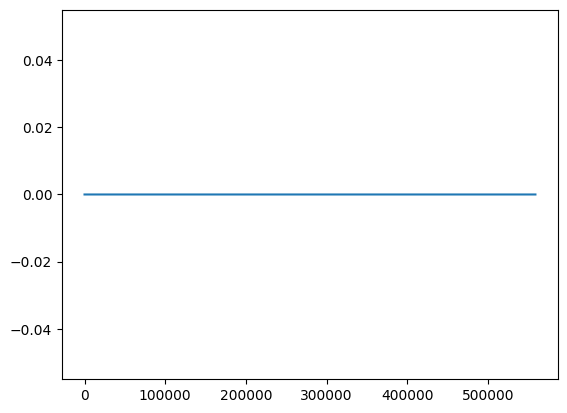

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc


#source_file1 = "/gpfs/wolf2/cades/cli185/proj-shared/Daymet_GSWP3_4KM_TESSFA/ELMinputdata/AOI_data/MOFLUX/AOI_domain1D/MOFlux_domain.lnd.Daymet_GSWP3_TESSFA.4km.1d.c231120.nc"
#source_file1 = "/gpfs/wolf2/cades/cli185/proj-shared/Daymet_GSWP3_4KM_TESSFA/ELMinputdata/AOI_data/MOFLUX/AOI_domain1D/MOF21points_domain.lnd.Daymet_GSWP3_TESSFA.4km.1d.c231120.nc"
#source_file2 = "/gpfs/wolf2/cades/cli185/proj-shared/Daymet_GSWP3_4KM_TESSFA/ELMinputdata/AOI_data/MOFLUX/AOI_surfdata1D/MOFlux_surfdata.lnd.Daymet_GSWP3_TESSFA.4km.1d.nc"
#source_file2 = "/gpfs/wolf2/cades/cli185/proj-shared/Daymet_GSWP3_4KM_TESSFA/ELMinputdata/AOI_data/MOFLUX/AOI_surfdata1D/MOF21points_surfdata.lnd.Daymet_GSWP3_TESSFA.4km.1d.nc"

#source_file1 = "/gpfs/wolf2/cades/cli185/proj-shared/Daymet_GSWP3_4KM_TESSFA/ELMinputdata/domain1D_TES/domain.lnd.Daymet_GSWP3_TESSFA.4km.1d.c231120.nc"
#source_file2 = "/gpfs/wolf2/cades/cli185/proj-shared/Daymet_GSWP3_4KM_TESSFA/ELMinputdata/surfdata1D_TES/surfdata.lnd.Daymet_GSWP3_TESSFA.4km.1d.nc"

source_file1 = "/gpfs/wolf2/cades/cli185/proj-shared/wangd/kiloCraft/NA_domainGEN/domain.lnd.Daymet_GSWP3_TESSFA.4km.1d.c240326.nc"
#source_file2 = "/gpfs/wolf2/cades/cli185/proj-shared/wangd/kiloCraft/NA_surfdataGEN/surfdata.Daymet_GSWP3_TESSFA.4km.1d.c240316c"
source_file2 = "/gpfs/wolf2/cades/cli185/proj-shared/wangd/kiloCraft/NA_surfdataGEN/surfdata.lnd.Daymet_GSWP3_TESSFA.4km.1d.c240316.nc"

src1 = nc.Dataset(source_file1, 'r', format='NETCDF4')
src2 = nc.Dataset(source_file2, 'r', format='NETCDF4')

lat1= src1['yc'][:]
lon1= src1['xc'][:]
lat2= src2['LATIXY'][:]
lon2= src2['LONGXY'][:]


rlat= lat1-lat2
plt.plot(rlat[0,:])
plt.show()

src2.close()
src1.close()


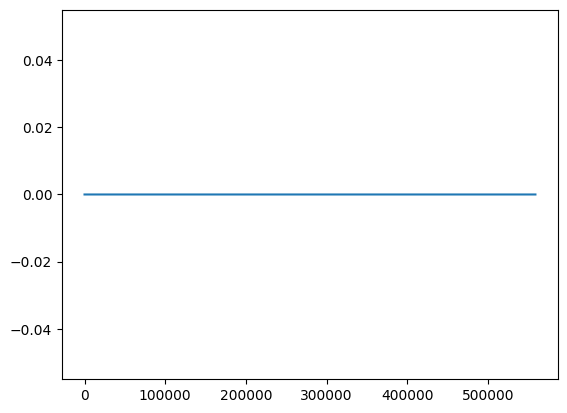

In [19]:
rlon= lon1-lon3
plt.plot(rlon[0,:])
plt.show()

In [13]:
src2.close()

src2 = nc.Dataset(source_file2, 'r+', format='NETCDF4')  # 'r+' for read/write access

# Read the variables from the first source file
lat1 = src1['yc'][:]
lon1 = src1['xc'][:]

# Replace the values of variables in the second source file
src2['LATIXY'][:] = lat1
src2['LONGXY'][:] = lon1

# Close the source files
src1.close()
src2.close()

RuntimeError: NetCDF: Not a valid ID

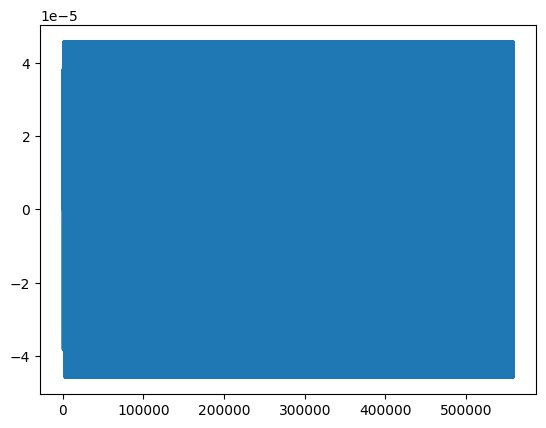

In [12]:
rlon= lon1-lon2
plt.plot(rlon[0,:])
plt.show()

In [6]:
lat1.shape, lat2.shape

((1, 558794), (558794,))

In [71]:
lat1= src1['yc'][:]
lon1= src1['xc'][:]
lat2= src2['LATIXY'][:]
lon2= src2['LONGXY'][:]

In [78]:
rlon= lon1-lon2
rlon.shape

(1, 576)

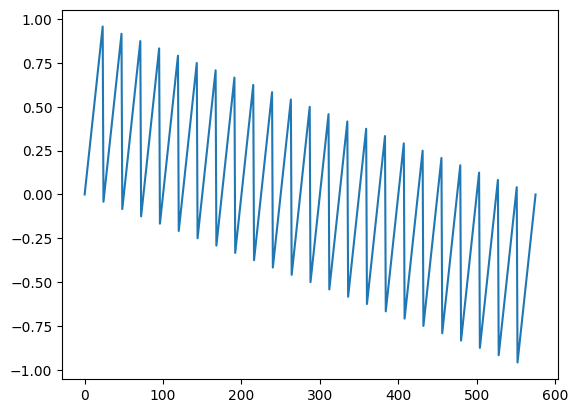

In [87]:
import matplotlib.pyplot as plt
import numpy as np
rlat= lat1-lat2
plt.plot(rlat[0,:])
plt.show()